In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet

In [2]:
df=pd.read_excel("output.xlsx")

In [3]:
df=df[["Date","Total_Amount"]]

In [4]:
df = df.groupby('Date')['Total_Amount'].sum().reset_index()

In [5]:
df.head()

,Date,Total_Amount
0,2023-03-01,1.104406e+06
1,2023-03-02,1.123873e+06
2,2023-03-03,1.097692e+06
3,2023-03-04,1.081359e+06
4,2023-03-05,1.153814e+06


In [6]:
df['Total_Amount']=df['Total_Amount']/1000
df.head()

,Date,Total_Amount
0,2023-03-01,1104.405891
1,2023-03-02,1123.873171
2,2023-03-03,1097.692147
3,2023-03-04,1081.358628
4,2023-03-05,1153.813747


In [7]:
df['Total_Amount']=round(df['Total_Amount'],2)
df.head()

,Date,Total_Amount
0,2023-03-01,1104.41
1,2023-03-02,1123.87
2,2023-03-03,1097.69
3,2023-03-04,1081.36
4,2023-03-05,1153.81


In [8]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Total_Amount'].quantile(0.25)
Q3 = df['Total_Amount'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define outliers based on 1.5*IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with boundary values
df['Total_Amount'] = df['Total_Amount'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Print DataFrame after replacing outliers
print("DataFrame after replacing outliers:")
print(df)


DataFrame after replacing outliers:
          Date  Total_Amount
0   2023-03-01       1104.41
1   2023-03-02       1123.87
2   2023-03-03       1097.69
3   2023-03-04       1081.36
4   2023-03-05       1153.81
..         ...           ...
361 2024-02-25       1066.05
362 2024-02-26       1115.84
363 2024-02-27       1199.35
364 2024-02-28       1151.96
365 2024-02-29       1191.36

[366 rows x 2 columns]


In [9]:
df.count()

Date            366
Total_Amount    366
dtype: int64

In [10]:
def check_stationarity(df):
    result = adfuller(df['Total_Amount'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
        return False
    return True

# Set index as Date
df.set_index('Date', inplace=True)

# Check if the data is stationary
is_stationary = check_stationarity(df)


ADF Statistic: -17.76819835240812
p-value: 3.316154735036888e-30
Critial Values:
   1%, -3.4483935212959844
Critial Values:
   5%, -2.8694912343676497
Critial Values:
   10%, -2.571005879151811
The series is stationary.


C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Total_Amount   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1968.097
Date:                Sun, 18 Aug 2024   AIC                           3942.193
Time:                        11:37:53   BIC                           3953.893
Sample:                    03-01-2023   HQIC                          3946.843
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0706      0.051      1.372      0.170      -0.030       0.172
ma.L1         -0.9999      0.439     -2.279      0.023      -1.860      -0.140
sigma2      2780.3689   1251.303      2.222      0.0

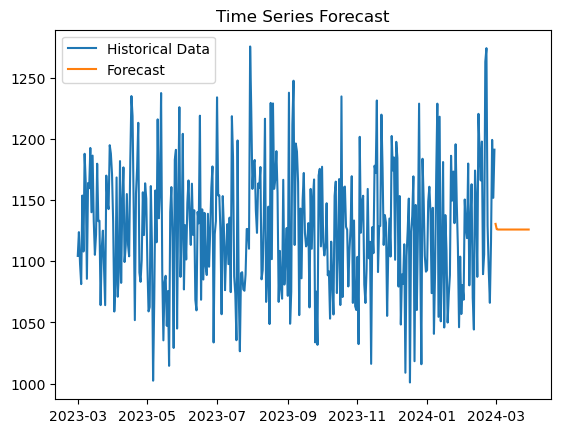

In [11]:
# Fit the ARIMA model 
model = ARIMA(df['Total_Amount'], order=(1, 1, 1))  # Assuming the first differencing made it stationary
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=30)  # Forecast next 30 steps
print(forecast)

# Plotting the forecast
plt.plot(df.index, df['Total_Amount'], label='Historical Data')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='D')[1:], forecast, label='Forecast')
plt.title('Time Series Forecast')
plt.legend()
plt.show()


In [12]:
# In above model forcasted values are constant 
# so we have to fine-tune parameter (p,d,q)
# we ploted ACF & PACF graph for finding p and q value

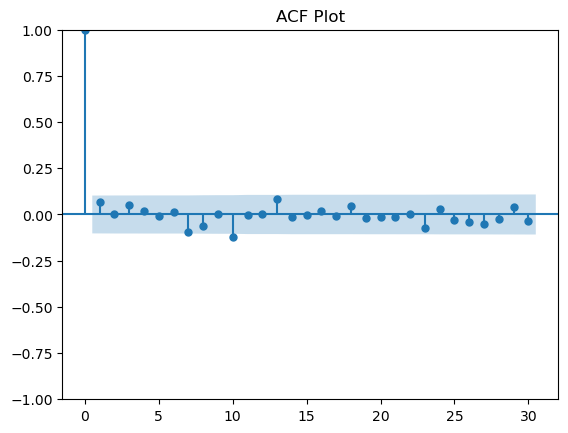

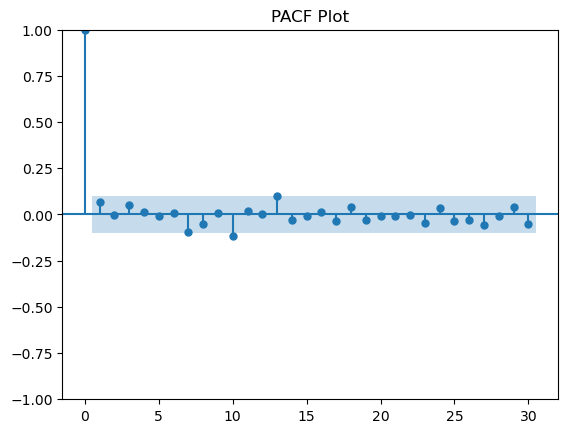

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF(q) and PACF(p)
plot_acf(df['Total_Amount'], lags=30)
plt.title('ACF Plot')
plt.show()

plot_pacf(df['Total_Amount'], lags=30)
plt.title('PACF Plot')
plt.show()


C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 49.88641937961293
Mean Squared Error (MSE): 3478.7882756226127
Root Mean Squared Error (RMSE): 58.98125359487209


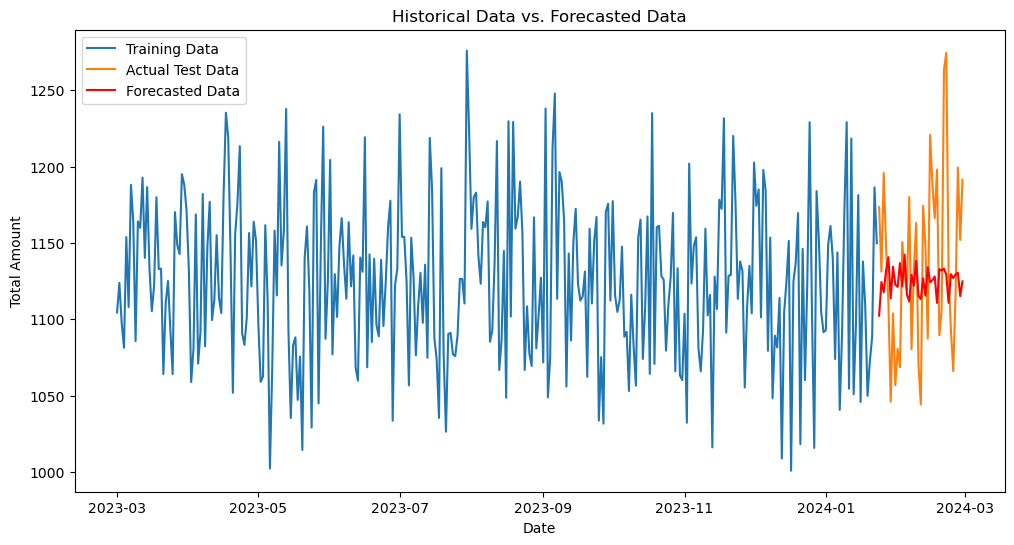

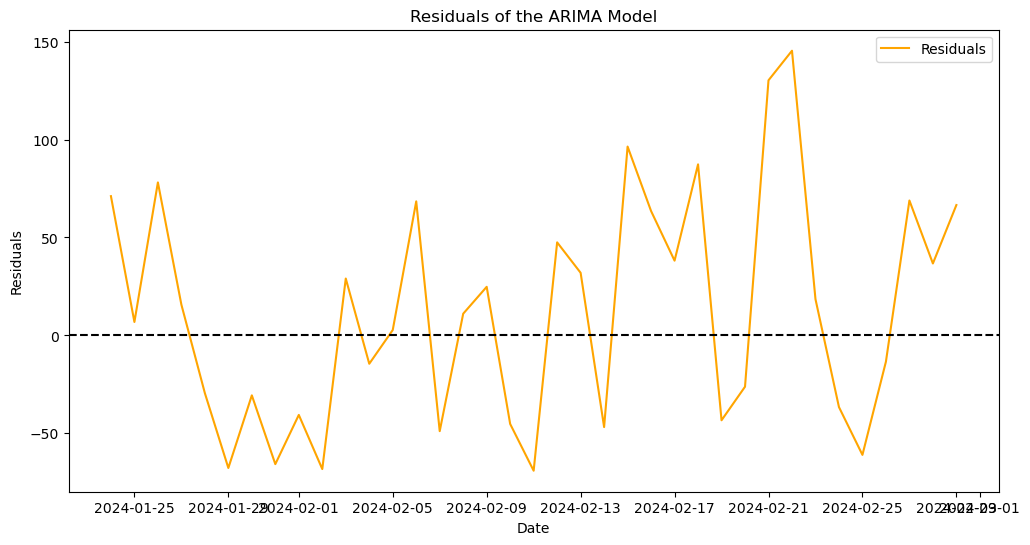

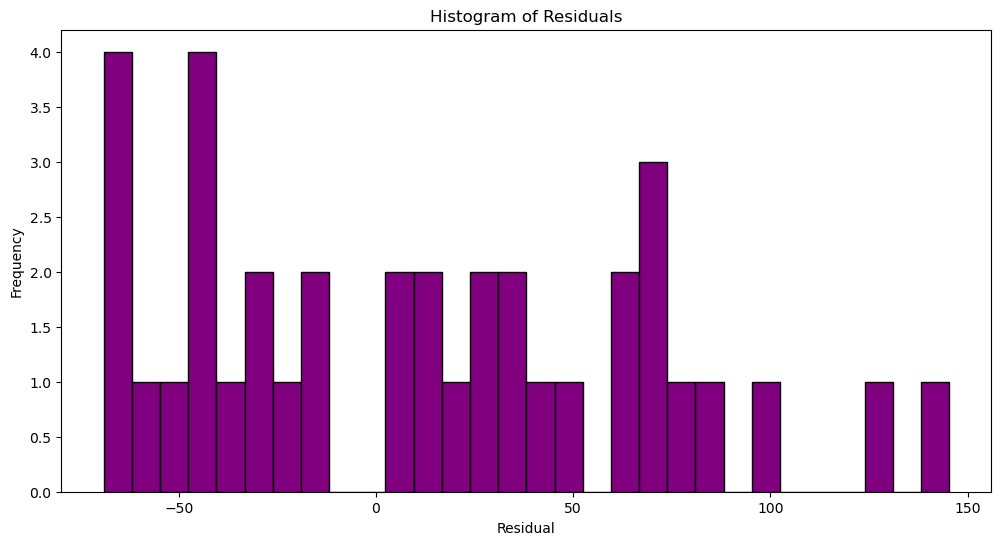

In [14]:
p, d, q = 10, 0, 10  # Example values, replace with your actual values

# Split the data into training and test sets
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

# Fit the ARIMA model on the training data
model = ARIMA(train['Total_Amount'], order=(p, d, q))
model_fit = model.fit()

# Forecast on the test set
forecast = model_fit.forecast(steps=len(test))
forecast_series = pd.Series(forecast, index=test.index)

# Calculate accuracy metrics
mae = mean_absolute_error(test['Total_Amount'], forecast_series)
mse = mean_squared_error(test['Total_Amount'], forecast_series)
rmse = np.sqrt(mse)
r2 = r2_score(test['Total_Amount'], forecast_series)

# Print accuracy metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)


# Plot Historical Data vs. Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total_Amount'], label='Training Data')
plt.plot(test.index, test['Total_Amount'], label='Actual Test Data')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Historical Data vs. Forecasted Data')
plt.legend()
plt.show()

# Plot Residuals
residuals = test['Total_Amount'] - forecast_series

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of the ARIMA Model')
plt.legend()
plt.show()

# Optional: Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


### Forecasting Using Pophet Model

In [15]:
df.reset_index("Date",inplace=True)

In [16]:
df = df.rename(columns={'Date': 'ds', 'Total_Amount': 'y'})

In [17]:
df.head()

,ds,y
0,2023-03-01,1104.41
1,2023-03-02,1123.87
2,2023-03-03,1097.69
3,2023-03-04,1081.36
4,2023-03-05,1153.81


11:38:07 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing


            ds        y
336 2024-01-31  1056.87
337 2024-02-01  1080.64
338 2024-02-02  1068.58
339 2024-02-03  1150.58
340 2024-02-04  1127.91
341 2024-02-05  1118.99
342 2024-02-06  1180.02
343 2024-02-07  1080.33
344 2024-02-08  1133.00
345 2024-02-09  1163.07
346 2024-02-10  1070.05
347 2024-02-11  1044.18
348 2024-02-12  1174.28
349 2024-02-13  1147.45
350 2024-02-14  1087.30
351 2024-02-15  1220.68
352 2024-02-16  1189.06
353 2024-02-17  1166.19
354 2024-02-18  1198.01
355 2024-02-19  1089.50
356 2024-02-20  1105.79
357 2024-02-21  1263.35
358 2024-02-22  1274.43
359 2024-02-23  1129.23
360 2024-02-24  1092.95
361 2024-02-25  1066.05
362 2024-02-26  1115.84
363 2024-02-27  1199.35
364 2024-02-28  1151.96
365 2024-02-29  1191.36
            ds         yhat   yhat_lower   yhat_upper
366 2024-03-01  1143.909150  1077.689878  1208.990742
367 2024-03-02  1127.382165  1065.875748  1198.564791
368 2024-03-03  1126.420159  1057.079645  1197.870897
369 2024-03-04  1125.722969  1055.947071

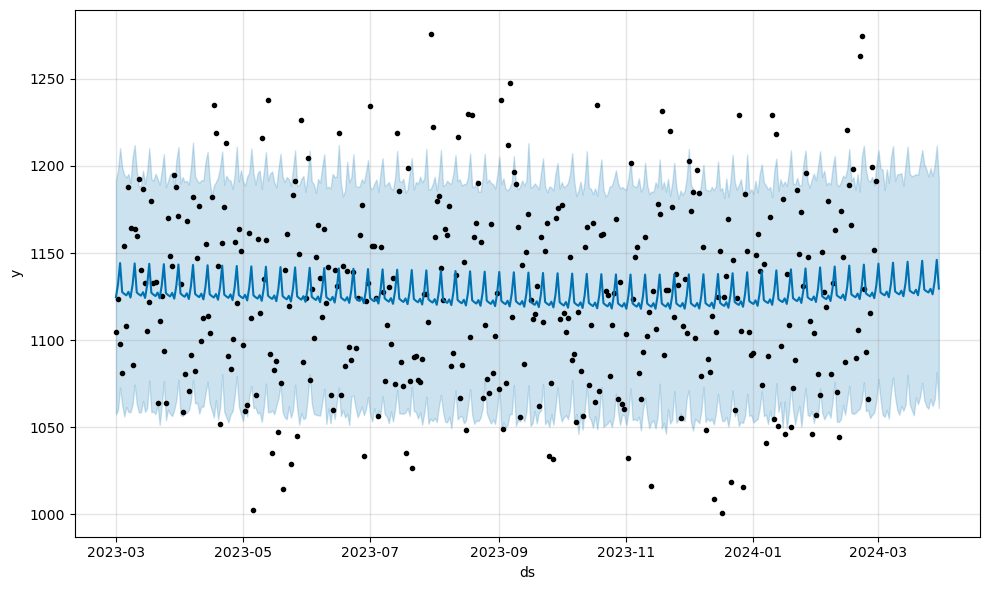

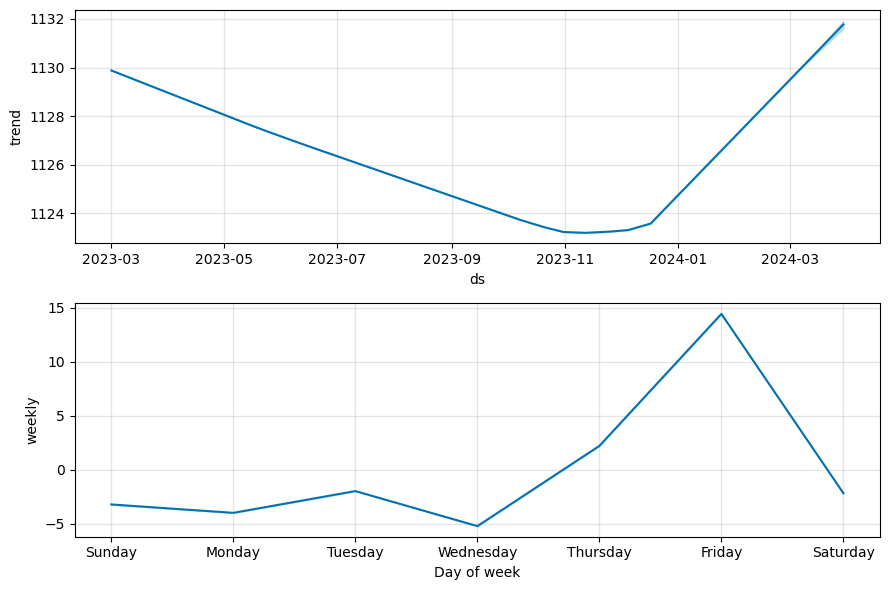

In [18]:
# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(df)

# Create a dataframe to hold the predictions for the next 30 days
future = model.make_future_dataframe(periods=30)

# Predict the future values
forecast = model.predict(future)

#show tail values of df and forcast
print(df.tail(30))
print(forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail(30))

# Evaluate accuracy 
# Here we calculate MAE and RMSE for the available historical data

# Actual vs Predicted on historical data
y_true = df['y'].values
y_pred = forecast['yhat'][:-30].values  # Exclude the last 15 days (future predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Root Mean Square Error (RMSE)
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Print results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

#Plot the forecast
model.plot(forecast)

model.plot_components(forecast)
plt.show()

In [20]:
future.head()

,ds
0,2023-03-01
1,2023-03-02
2,2023-03-03
3,2023-03-04
4,2023-03-05


### SARIMA

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

In [22]:
df = df.rename(columns={'ds':'Date' , 'y':'Total_Amount' })

In [23]:
df.head()

,Date,Total_Amount
0,2023-03-01,1104.41
1,2023-03-02,1123.87
2,2023-03-03,1097.69
3,2023-03-04,1081.36
4,2023-03-05,1153.81


In [43]:
# Example values for (p, d, q) and (P, D, Q, m) - assuming weekly seasonality
p, d, q = 1, 0, 1
P, D, Q, m = 1, 0, 1, 7  # m = 7 for weekly seasonality

In [44]:
# Split the data into training and test sets
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

# Initialize and fit the StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Total_Amount']])
test_scaled = scaler.transform(test[['Total_Amount']])


In [45]:
# Fit the SARIMA model on the scaled training data
model = SARIMAX(train_scaled, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit(disp=False)


In [46]:
# Forecast on the scaled test set
forecast_scaled = model_fit.forecast(steps=len(test_scaled))
forecast_series_scaled = pd.Series(forecast_scaled, index=test.index)

# Inverse transform the forecasted data
forecast_series = scaler.inverse_transform(forecast_series_scaled.values.reshape(-1, 1))
forecast_series = pd.Series(forecast_series.flatten(), index=test.index)


In [47]:
# Calculate accuracy metrics
mae = mean_absolute_error(test['Total_Amount'], forecast_series)
mse = mean_squared_error(test['Total_Amount'], forecast_series)
rmse = np.sqrt(mse)


# Print accuracy metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)



Mean Absolute Error (MAE): 46.65826013112097
Mean Squared Error (MSE): 3321.8934566729095
Root Mean Squared Error (RMSE): 57.63586953168061


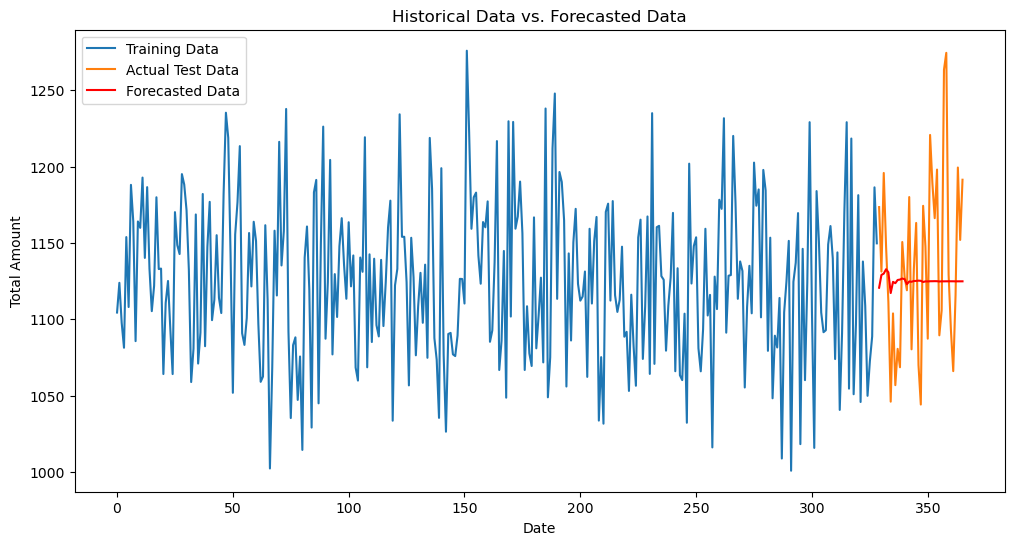

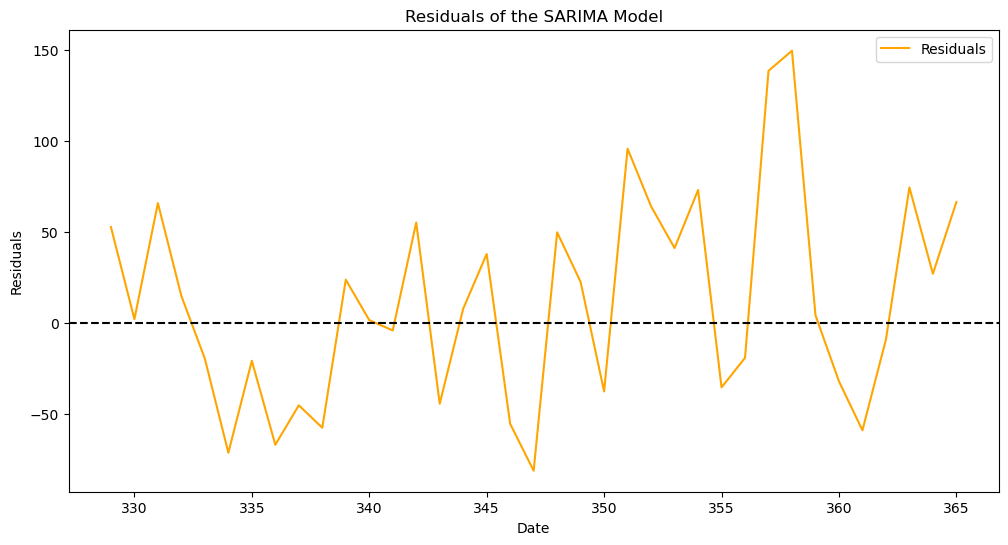

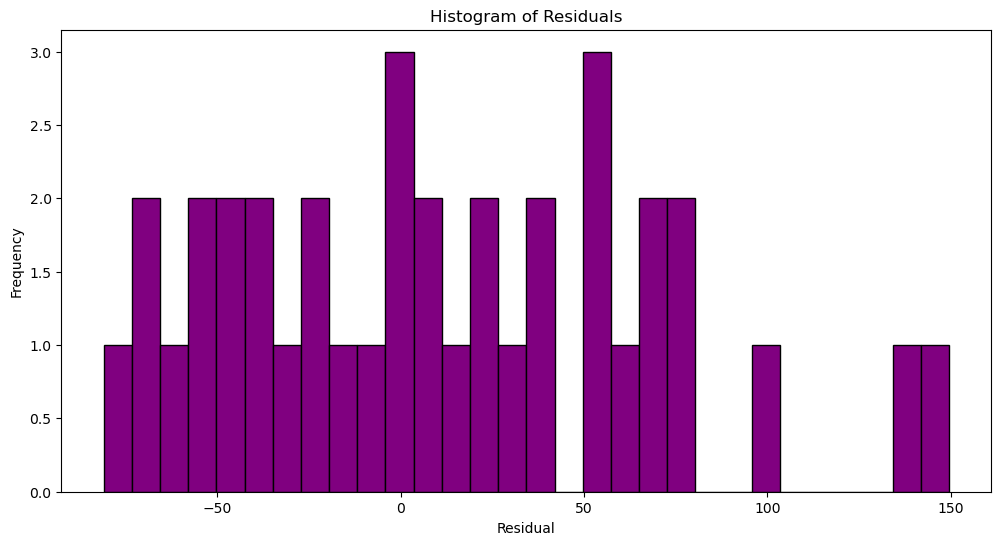

In [48]:
# Plot Historical Data vs. Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total_Amount'], label='Training Data')
plt.plot(test.index, test['Total_Amount'], label='Actual Test Data')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Historical Data vs. Forecasted Data')
plt.legend()
plt.show()

# Plot Residuals
residuals = test['Total_Amount'] - forecast_series

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of the SARIMA Model')
plt.legend()
plt.show()

# Optional: Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
